In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.applications import VGG16
from matplotlib import pyplot as plt
import keras.callbacks
import cv2

In [2]:
# SET GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
SEED = 123
N_CLASSES = 1
IMG_SIZE = 224
BUFFER_SIZE = 1000
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
file_data = "data/data.csv"
data = pd.read_csv(file_data)
data = data.to_numpy()
data[:5]

array([['dataset/training/image_2/umm_000000.png',
        'dataset/training/gt_image_2/umm_road_000000.png'],
       ['dataset/training/image_2/umm_000001.png',
        'dataset/training/gt_image_2/umm_road_000001.png'],
       ['dataset/training/image_2/umm_000002.png',
        'dataset/training/gt_image_2/umm_road_000002.png'],
       ['dataset/training/image_2/umm_000003.png',
        'dataset/training/gt_image_2/umm_road_000003.png'],
       ['dataset/training/image_2/umm_000004.png',
        'dataset/training/gt_image_2/umm_road_000004.png']], dtype=object)

In [5]:
TRAIN_SIZE = int(0.8 * len(data))
VAL_SIZE = int(0.1 * len(data))
TEST_SIZE = int(0.1 * len(data))

In [6]:
@tf.function
def read_img(data):
    # Input image
    img = tf.io.read_file(data[0])
    img = tf.image.decode_jpeg(img)
    # Output segment
    segment = tf.io.read_file(data[1])
    segment = tf.image.decode_jpeg(segment)
    rgb_road = tf.constant([255, 0, 255], dtype=tf.uint8)
    segment = tf.reduce_all(segment == rgb_road, axis= 2)
    segment = tf.cast(segment, dtype=tf.uint8)
    segment_shape = tf.shape(segment)
    segment = tf.reshape(segment, (segment_shape[0], segment_shape[1], 1))
    return img, segment

def display_image_segment(img, segment):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(img)
    axs[1].imshow(segment, cmap='gray', vmin=0, vmax=1)

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.map(read_img)

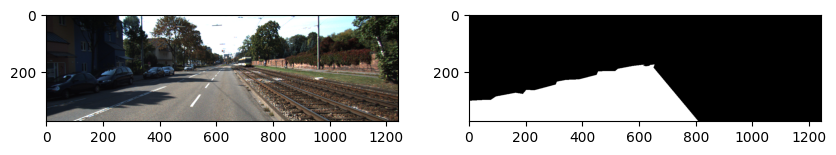

In [8]:
a = [d for d in dataset.take(1)][0]
display_image_segment(a[0], a[1])

In [9]:
dataset = dataset.shuffle(BUFFER_SIZE, seed= SEED)
train_data = dataset.take(TRAIN_SIZE)
val_data = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_data = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

In [10]:
# Create a generator.
rng = tf.random.Generator.from_seed(SEED, alg='philox')

@tf.function
def data_augmentation(img:tf.Tensor, segment:tf.Tensor):
    seed = rng.make_seeds(2)[0]

    img = tf.image.stateless_random_brightness(img, max_delta= 0.8, seed= seed)
    img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality= 75, max_jpeg_quality= 100, seed= seed)
    
    img = tf.image.stateless_random_flip_left_right(img, seed= seed,)
    segment = tf.image.stateless_random_flip_left_right(segment, seed= seed)

    return img, segment

@tf.function
def resize_and_rescale(img:tf.Tensor, segment:tf.Tensor):
    img = tf.cast(img, tf.float16)
    img = img / 255.0
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    segment = tf.image.resize(segment, (IMG_SIZE, IMG_SIZE))
    return img , segment

@tf.function
def preprocess(ds:tf.data.Dataset, augment=False)->tf.data.Dataset:
    ds = ds.map(resize_and_rescale, num_parallel_calls= AUTOTUNE)
    if augment:
        ds = ds.map(data_augmentation, num_parallel_calls= AUTOTUNE)
        ds = ds.shuffle(BUFFER_SIZE, seed=SEED)
    return ds

In [11]:
# Set up data
train_data = train_data.repeat(1)
train_data = preprocess(train_data, True)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(AUTOTUNE)

val_data = preprocess(val_data)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.prefetch(AUTOTUNE)

test_data = preprocess(test_data)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTOTUNE)

In [12]:
def display_result_image(img, segment):
    zero_array = np.zeros_like(segment)
    segment_img = np.dstack((zero_array, segment, zero_array)) # Green
    result_img = cv2.addWeighted(src1= img, alpha= 1.0, src2= segment_img, beta= 0.5, gamma= 0)
    plt.imshow(result_img)
    plt.show()

In [13]:
inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
base_model = VGG16(include_top=False, weights="imagenet", input_tensor= inputs)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
def upsample_block(block_input, block_counterpart, channel):
    # Upsampling block
    uppool = layers.Conv2DTranspose(channel, kernel_size= 2, strides= 2)(block_input)
    concat = layers.Add()([uppool, block_counterpart])
    conv = layers.Conv2D(filters=channel, kernel_size=1, activation= 'sigmoid')(concat)
    return conv

In [15]:
# Unet
base_model.trainable = False

b1_pool = base_model.get_layer("block1_pool").output
b2_pool = base_model.get_layer("block2_pool").output
b3_pool = base_model.get_layer("block3_pool").output
b4_pool = base_model.get_layer("block4_pool").output
b5_pool = base_model.get_layer("block5_pool").output

u5 = upsample_block(b5_pool, b4_pool, 512)
u4 = upsample_block(u5, b3_pool, 256)
u3 = upsample_block(u4, b2_pool, 128)
u2 = upsample_block(u3, b1_pool, 64)

u1 = layers.Conv2DTranspose(N_CLASSES, kernel_size= 2, strides= 2)(u2)
outputs = layers.Conv2D(N_CLASSES, 1, activation= 'sigmoid')(u1)

In [16]:
model = Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath= "Model road segment", save_best_only= True),
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta= 1e-4, patience= 5)
]

model.compile(
    optimizer= keras.optimizers.Adam(),
    loss= keras.losses.BinaryCrossentropy(),
    metrics= keras.metrics.BinaryAccuracy(),
)

In [18]:
model.fit(
    train_data,
    epochs= 100,
    validation_data= val_data,
    callbacks= callbacks
)

Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 0.5910 - binary_accuracy: 0.8012

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 29s 190ms/step - loss: 0.5910 - binary_accuracy: 0.8012 - val_loss: 0.5227 - val_binary_accuracy: 0.8127
Epoch 2/100
57/58 [============================>.] - ETA: 0s - loss: 0.4902 - binary_accuracy: 0.8182

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 10s 136ms/step - loss: 0.4898 - binary_accuracy: 0.8184 - val_loss: 0.4787 - val_binary_accuracy: 0.8146
Epoch 3/100
58/58 [==============================] - 7s 82ms/step - loss: 0.4711 - binary_accuracy: 0.8188 - val_loss: 0.4883 - val_binary_accuracy: 0.8067
Epoch 4/100
57/58 [============================>.] - ETA: 0s - loss: 0.4636 - binary_accuracy: 0.8231

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 10s 134ms/step - loss: 0.4639 - binary_accuracy: 0.8229 - val_loss: 0.4691 - val_binary_accuracy: 0.8194
Epoch 5/100
58/58 [==============================] - 7s 82ms/step - loss: 0.4653 - binary_accuracy: 0.8219 - val_loss: 0.4931 - val_binary_accuracy: 0.8036
Epoch 6/100
57/58 [============================>.] - ETA: 0s - loss: 0.4617 - binary_accuracy: 0.8234

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 10s 146ms/step - loss: 0.4616 - binary_accuracy: 0.8234 - val_loss: 0.4421 - val_binary_accuracy: 0.8320
Epoch 7/100
57/58 [============================>.] - ETA: 0s - loss: 0.4361 - binary_accuracy: 0.8172

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 11s 153ms/step - loss: 0.4348 - binary_accuracy: 0.8175 - val_loss: 0.3695 - val_binary_accuracy: 0.8061
Epoch 8/100
57/58 [============================>.] - ETA: 0s - loss: 0.2821 - binary_accuracy: 0.8735

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 10s 141ms/step - loss: 0.2819 - binary_accuracy: 0.8737 - val_loss: 0.1923 - val_binary_accuracy: 0.9369
Epoch 9/100
57/58 [============================>.] - ETA: 0s - loss: 0.1904 - binary_accuracy: 0.9287

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 10s 135ms/step - loss: 0.1901 - binary_accuracy: 0.9288 - val_loss: 0.1511 - val_binary_accuracy: 0.9445
Epoch 10/100
57/58 [============================>.] - ETA: 0s - loss: 0.1748 - binary_accuracy: 0.9298

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 10s 137ms/step - loss: 0.1742 - binary_accuracy: 0.9301 - val_loss: 0.1321 - val_binary_accuracy: 0.9489
Epoch 11/100
57/58 [============================>.] - ETA: 0s - loss: 0.1576 - binary_accuracy: 0.9334

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 10s 139ms/step - loss: 0.1577 - binary_accuracy: 0.9334 - val_loss: 0.1087 - val_binary_accuracy: 0.9574
Epoch 12/100
57/58 [============================>.] - ETA: 0s - loss: 0.1477 - binary_accuracy: 0.9376

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 10s 133ms/step - loss: 0.1483 - binary_accuracy: 0.9372 - val_loss: 0.1047 - val_binary_accuracy: 0.9604
Epoch 13/100
58/58 [==============================] - 7s 82ms/step - loss: 0.1418 - binary_accuracy: 0.9408 - val_loss: 0.1070 - val_binary_accuracy: 0.9572
Epoch 14/100
58/58 [==============================] - 7s 82ms/step - loss: 0.1383 - binary_accuracy: 0.9415 - val_loss: 0.1064 - val_binary_accuracy: 0.9572
Epoch 15/100
57/58 [============================>.] - ETA: 0s - loss: 0.1309 - binary_accuracy: 0.9435

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


58/58 [==============================] - 9s 131ms/step - loss: 0.1307 - binary_accuracy: 0.9437 - val_loss: 0.0783 - val_binary_accuracy: 0.9687
Epoch 16/100
58/58 [==============================] - 7s 81ms/step - loss: 0.1316 - binary_accuracy: 0.9422 - val_loss: 0.1034 - val_binary_accuracy: 0.9559
Epoch 17/100
58/58 [==============================] - 7s 81ms/step - loss: 0.1299 - binary_accuracy: 0.9435 - val_loss: 0.0921 - val_binary_accuracy: 0.9606
Epoch 18/100
58/58 [==============================] - 7s 82ms/step - loss: 0.1188 - binary_accuracy: 0.9481 - val_loss: 0.0827 - val_binary_accuracy: 0.9637
Epoch 19/100
58/58 [==============================] - 7s 84ms/step - loss: 0.1251 - binary_accuracy: 0.9457 - val_loss: 0.0786 - val_binary_accuracy: 0.9665
Epoch 20/100
58/58 [==============================] - 7s 81ms/step - loss: 0.1261 - binary_accuracy: 0.9451 - val_loss: 0.0888 - val_binary_accuracy: 0.9608


In [19]:
model.evaluate(test_data)

7/7 [==============================] - 1s 45ms/step - loss: 0.0887 - binary_accuracy: 0.9593


[0.08868246525526047, 0.9592954516410828]

1/1 [==============================] - 1s 1s/step


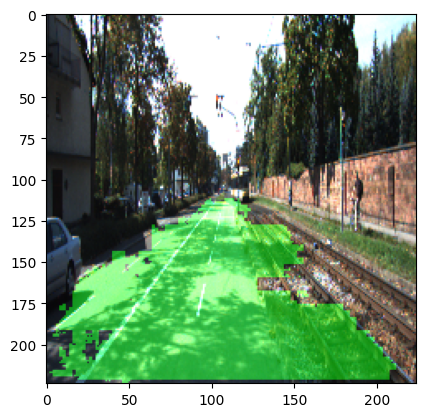

In [20]:
test = data[2]
img_test, mask_test = read_img(test)
img_test, mask_test = resize_and_rescale(img_test, mask_test)
mask_pred = model.predict(tf.expand_dims(img_test,0))[0]>0.5
img_test = img_test.numpy()
mask_test = mask_test.numpy()
mask_pred = np.array(mask_pred).astype(np.float32)
display_result_image(img_test, mask_pred)

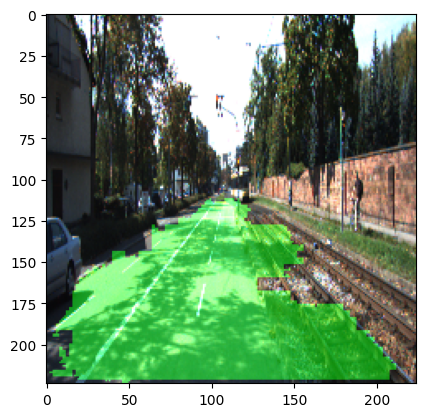

In [21]:
from skimage.morphology import remove_small_objects

mask_pred_1 = (mask_pred.astype(np.bool8)).reshape((IMG_SIZE, IMG_SIZE))
mask_pred_1 = remove_small_objects(mask_pred_1, 100)
mask_pred_1 = (mask_pred_1.astype(np.float32)).reshape((IMG_SIZE, IMG_SIZE, 1))

mask_pred_1 = (mask_pred_1.astype(np.bool8)).reshape((IMG_SIZE, IMG_SIZE))
mask_pred_1 = mask_pred_1 == 0
mask_pred_1 = remove_small_objects(mask_pred_1, 100)
mask_pred_1 = mask_pred_1 == 0
mask_pred_1 = (mask_pred_1.astype(np.float32)).reshape((IMG_SIZE, IMG_SIZE, 1))
display_result_image(img_test, mask_pred_1)

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model("Model road segment")
tflite_model = converter.convert()
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
